# FastCLIP Score Test on COCO Val 2014

We want to quantify the search results of different models on COCO Val 2014 dataset.

There are three types of search we would like to conduct:

> 1. Text to Image
> 2. Image to Image
> 3. Image to Text



### Image Dataset loading

In [120]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import pylab
import glob
import os
from marqo import Client

dataDir='./'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
#print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
#print('COCO supercategories: \n{}'.format(' '.join(nms)))


docker_path = 'http://[::]:8224/'
images_directory = 'images'

files = glob.glob(images_directory + "/*.jpg")
files_map = {os.path.basename(f):f for f in files}

files_docker = [f.replace(images_directory, docker_path) for f in files]

documents = [{"image_docker":file_docker, '_id':os.path.basename(file_docker)} 
             for file_docker,file_local in zip(files_docker, files)]


loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


### Index the images 

In [97]:
client = Client(url='http://localhost:8882')

index_name = 'coco-2017-val'

client.delete_index(index_name)

settings = {
        "model":'fast/ViT-B/32',
        "treat_urls_and_pointers_as_images": True,
        }
try:
    client.create_index(index_name, **settings)
except:
    client.delete_index(index_name)
    client.create_index(index_name, **settings)
    
    

In [98]:
client.index(index_name).add_documents(documents, device='cpu', processes=4, client_batch_size= 50)

2022-11-16 20:09:44,419 logger:'marqo' INFO starting batch ingestion with batch size 50
2022-11-16 20:09:46,493 logger:'marqo' INFO batch 0: ingested 50 docs. Time taken: 0:00:02.066281. Average timer per doc 0:00:00.041326
2022-11-16 20:09:48,262 logger:'marqo' INFO batch 1: ingested 50 docs. Time taken: 0:00:01.768753. Average timer per doc 0:00:00.035375
2022-11-16 20:09:50,023 logger:'marqo' INFO batch 2: ingested 50 docs. Time taken: 0:00:01.760969. Average timer per doc 0:00:00.035219
2022-11-16 20:09:51,822 logger:'marqo' INFO batch 3: ingested 50 docs. Time taken: 0:00:01.797825. Average timer per doc 0:00:00.035956
2022-11-16 20:09:53,600 logger:'marqo' INFO batch 4: ingested 50 docs. Time taken: 0:00:01.777597. Average timer per doc 0:00:00.035552
2022-11-16 20:09:55,386 logger:'marqo' INFO batch 5: ingested 50 docs. Time taken: 0:00:01.785437. Average timer per doc 0:00:00.035709
2022-11-16 20:09:57,187 logger:'marqo' INFO batch 6: ingested 50 docs. Time taken: 0:00:01.80082

2022-11-16 20:11:34,566 logger:'marqo' INFO batch 60: ingested 50 docs. Time taken: 0:00:01.854495. Average timer per doc 0:00:00.037090
2022-11-16 20:11:36,353 logger:'marqo' INFO batch 61: ingested 50 docs. Time taken: 0:00:01.787127. Average timer per doc 0:00:00.035743
2022-11-16 20:11:38,156 logger:'marqo' INFO batch 62: ingested 50 docs. Time taken: 0:00:01.801689. Average timer per doc 0:00:00.036034
2022-11-16 20:11:39,935 logger:'marqo' INFO batch 63: ingested 50 docs. Time taken: 0:00:01.779389. Average timer per doc 0:00:00.035588
2022-11-16 20:11:41,752 logger:'marqo' INFO batch 64: ingested 50 docs. Time taken: 0:00:01.815651. Average timer per doc 0:00:00.036313
2022-11-16 20:11:43,611 logger:'marqo' INFO batch 65: ingested 50 docs. Time taken: 0:00:01.858629. Average timer per doc 0:00:00.037173
2022-11-16 20:11:45,418 logger:'marqo' INFO batch 66: ingested 50 docs. Time taken: 0:00:01.806544. Average timer per doc 0:00:00.036131
2022-11-16 20:11:47,266 logger:'marqo' IN

[{'errors': False,
  'processingTimeMs': 2056.227,
  'index_name': 'coco-2017-val',
  'items': [{'_id': '000000182611.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000335177.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000278705.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000463618.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000568981.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000092416.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000173830.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000476215.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000479126.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000570664.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000304396.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000231339.jpg', 'result': 'created', 'status': 201},
   {'_id': '000000153510.jpg', 'result': 'created', 'status': 201},
   {'_id': '00000001105

# Text to Image Search Evaluation

The way we generate the searching query is randomly selecting several (1 to 3) labels and merge them into a string. For example, if we pick the labels "person" and "cat", the search query will be "person cat", and this is defined as a 2-label query.

We evalute the performances on 1-label query, 2-label query, 3-label query.

For a $n$-label query with $R$ resutls, the score is computed as

$$Score(n, M) = \sum_{i = 1} ^{R}\frac{100}{R^*}\times \frac{1}{n}\times Matched\,labels(result_i, groundtruth_i), $$

where $R^*$ is the expected number of results. 

$$R^* = \min \{R, \text{number of images with}\,n-\text{label}\}. $$

For exmaple, if the number of images with label "cat", "person" is __5__, and the $R = 10$, then $R^* = 5$. However, if the number of images is __40__ but $R = 10$, then $R^*$ = 10


The full mark is always __100__.


In [99]:
label1_list = [("person",), ("umbrella",), ("book",), ("sandwich",)]
label2_list = [("person", "cat",), ("pizza", "fork",), ("person", "bicycle",), ("cake", "knife",)]
label3_list = [("person", "dog", "sports",), ("person", "laptop", "phone",), ("suitcase", "light", "person",)]

label_list = label1_list + label2_list + label3_list

In [100]:
# Category Ids
for label_pairs in label_list:
    catIds = coco.getCatIds(catNms=label_pairs)
    # print the number of images including these labels
    imgIds = coco.getImgIds(catIds=catIds )
    print(len(imgIds))

2693
174
230
98
23
46
122
38
76
80
76


The label pair we choose can always return more than 10 images, and $R = 10$ in our search. So each search result worths 10 points, and each label worths $10 / n$ points

In [101]:
label_list

[('person',),
 ('umbrella',),
 ('book',),
 ('sandwich',),
 ('person', 'cat'),
 ('pizza', 'fork'),
 ('person', 'bicycle'),
 ('cake', 'knife'),
 ('person', 'dog', 'sports'),
 ('person', 'laptop', 'phone'),
 ('suitcase', 'light', 'person')]

### Text-to-image search result

In [102]:
for label_pair in label_list:
    search_string = "a " + " and ".join(label_pair)
    search_results = client.index("coco-2017-val").search(search_string, 
                        searchable_attributes=['image_docker'], 
                         device='cpu')
    score = 0
    
    for result in search_results["hits"]:
        img_id = int(result["_id"][6:12])
        anns = coco.loadAnns(coco.getAnnIds(imgIds = img_id))
        result_cat = []
        for an in anns:
            cat = coco.loadCats(an["category_id"])[0]
            result_cat.append(cat['name'])
        
        score += 10 * len(set(label_pair) & set(result_cat)) / len(label_pair)
        
    print(f"The score for searching \"{search_string}\" is {round(score)} %.")
        
    
        
        
        

The score for searching "a person" is 100 %.
The score for searching "a umbrella" is 100 %.
The score for searching "a book" is 90 %.
The score for searching "a sandwich" is 100 %.
The score for searching "a person and cat" is 80 %.
The score for searching "a pizza and fork" is 65 %.
The score for searching "a person and bicycle" is 75 %.
The score for searching "a cake and knife" is 70 %.
The score for searching "a person and dog and sports" is 47 %.
The score for searching "a person and laptop and phone" is 47 %.
The score for searching "a suitcase and light and person" is 50 %.


## Image to Image Search

Similarly, the queried images should have similar labels with the original one.

In [123]:
image_search_labels = label2_list.copy()

image_search_labels

[('person', 'cat'),
 ('pizza', 'fork'),
 ('person', 'bicycle'),
 ('cake', 'knife')]

In [124]:
start_image_id = []

for label_pairs in image_search_labels:
    catIds = coco.getCatIds(catNms=label_pairs)
    # print the number of images including these labels
    imgIds = coco.getImgIds(catIds=catIds)
    start_image_id.append(imgIds[0])
    
start_image_id




[223747, 312192, 184324, 376322]

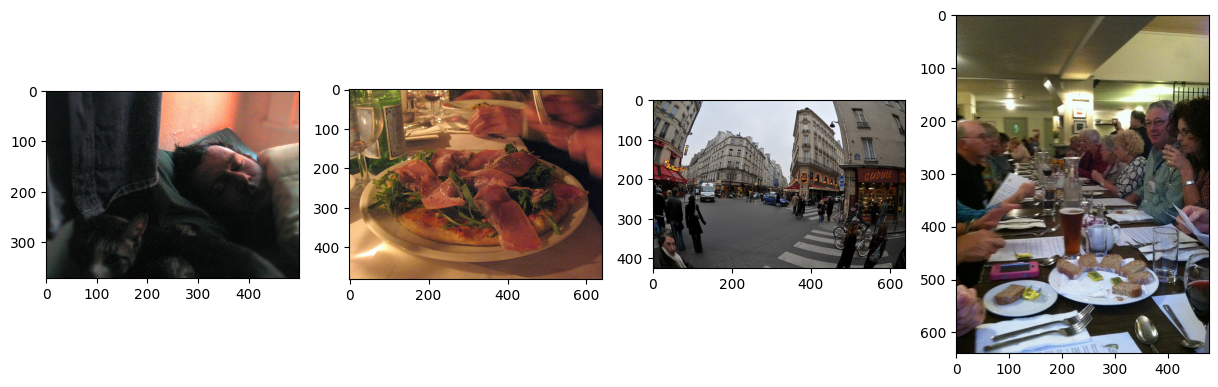

In [129]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(15,8))

imgs_name = [coco.loadImgs(id_number)[0]["file_name"] for id_number in start_image_id]

for i, img_name in enumerate(imgs_name):
    local_path_img_name = images_directory +"/" + img_name
    img = Image.open(local_path_img_name)
    axes[i].imshow(img)
plt.show()

In [127]:
imgs_name

['000000223747.jpg',
 '000000312192.jpg',
 '000000184324.jpg',
 '000000376322.jpg']

### Image-to-image search result

The way we score the the image-to-image search is to find the same number of labels between the original image and the searched iamge, and normalize it by the total number of label.

__Note: I think it's not a good idea to score image_to_image search. I didn't find a good way to quantify this similarity between images. The matching between text labels can not demonstrate our visual feelings.__

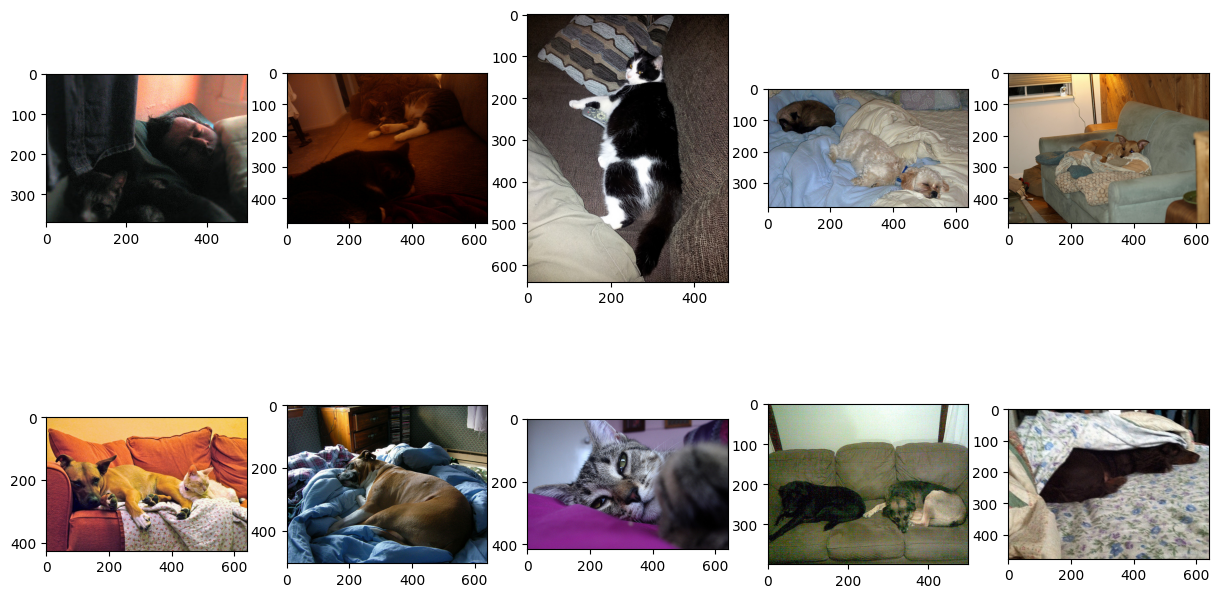

The score for searching "('person', 'cat')" is 35 %.


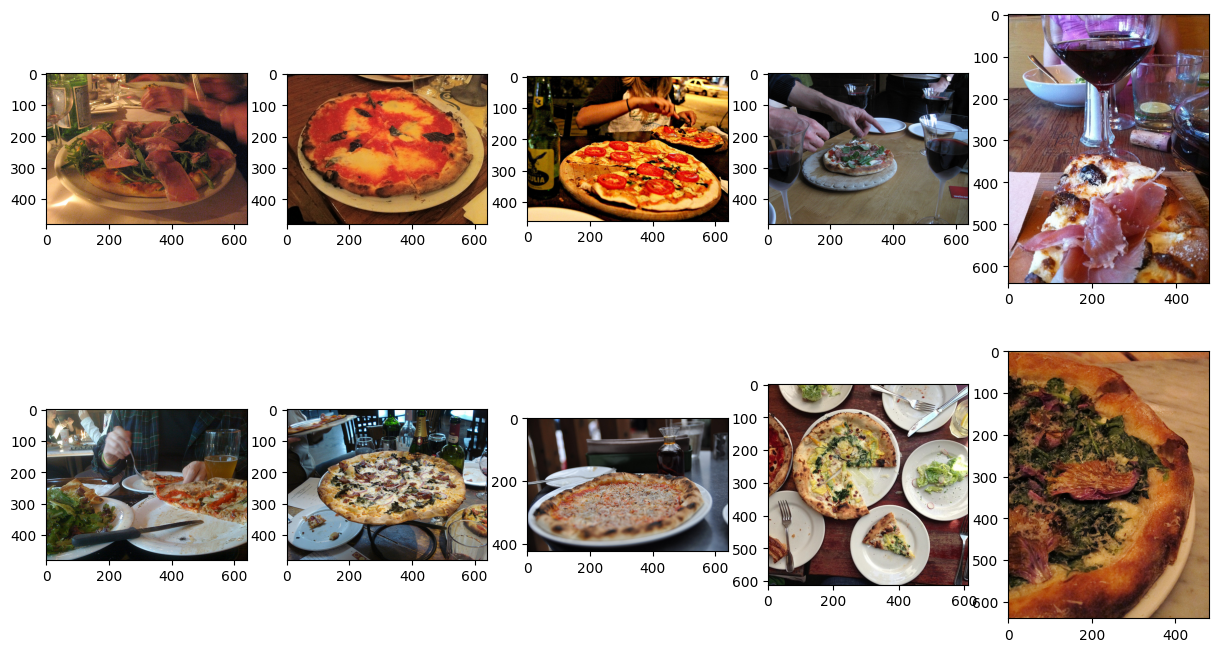

The score for searching "('pizza', 'fork')" is 75 %.


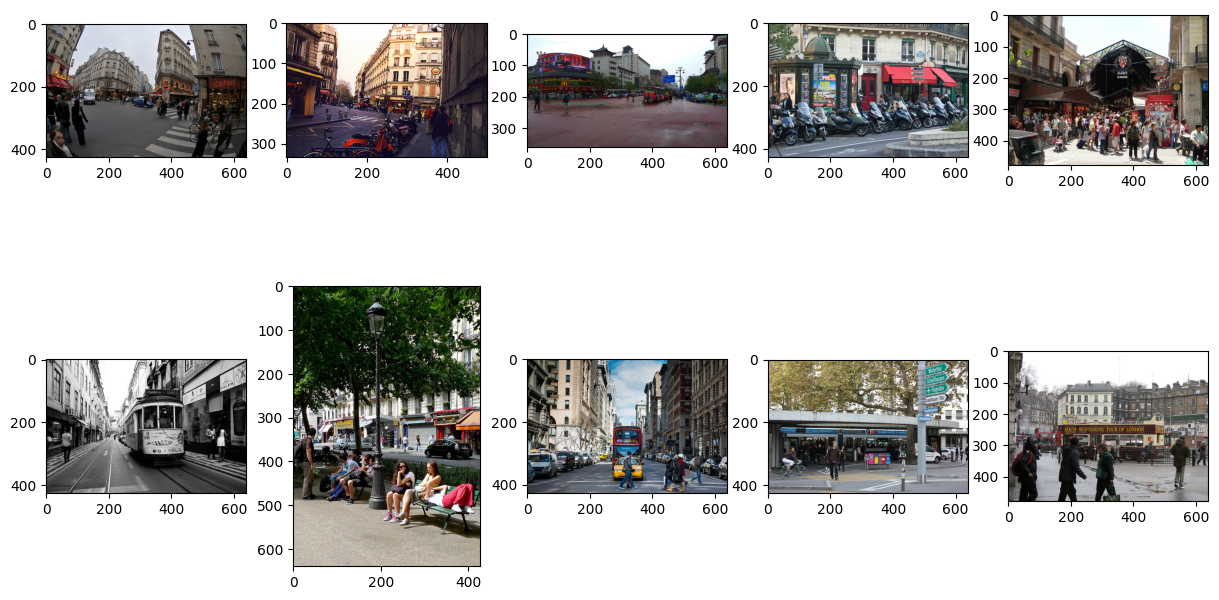

The score for searching "('person', 'bicycle')" is 70 %.


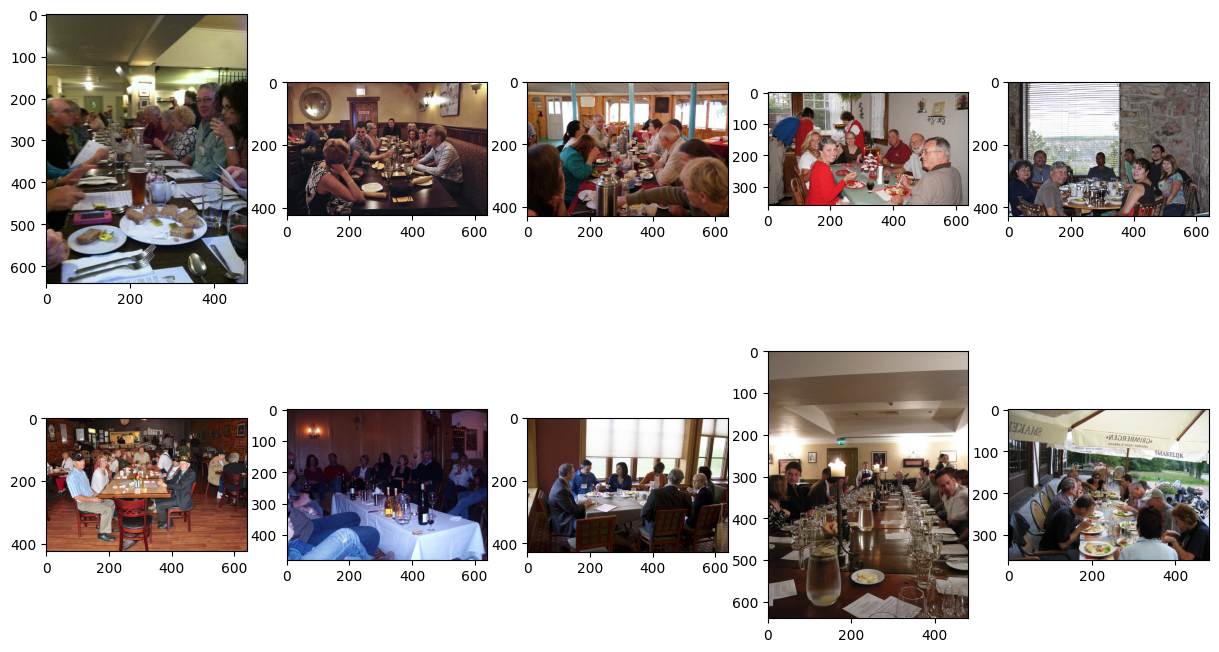

The score for searching "('cake', 'knife')" is 35 %.


In [132]:
for search_label, img_name in zip(image_search_labels, imgs_name):
    search_results = client.index("coco-2017-val").search(docker_path + img_name, 
                        searchable_attributes=['image_docker'], 
                         device='cpu')
    score = 0
    
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15,8))

    for i, result in enumerate(search_results["hits"]):
        img_name = result["image_docker"]
        local_path_img_name = img_name.replace(docker_path, images_directory)
        img = Image.open(local_path_img_name)
        axes[i//5,i%5].imshow(img)
    plt.show()
    
    
    
    for result in search_results["hits"]:
        img_id = int(result["_id"][6:12])
        anns = coco.loadAnns(coco.getAnnIds(imgIds = img_id))
        result_cat = []
        for an in anns:
            cat = coco.loadCats(an["category_id"])[0]
            result_cat.append(cat['name'])
        
        score += 10 * len(set(search_label) & set(result_cat)) / len(search_label)
        
    print(f"The score for searching \"{search_label}\" is {round(score)} %.")
        

## Image to Text Search

Here, we use the captions provided by the image dataset as our dataset.

In [113]:
capFile='{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_cap=COCO(capFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [114]:
annIds = coco_cap.getAnnIds()
anns = coco_cap.loadAnns(annIds)


cap_documents = [{"Caption" : cap['caption'], "image_id" : cap['image_id']} for cap in anns]



In [115]:
index_name = 'coco-2017-cap'

client.delete_index(index_name)

settings = {
        "model":'fast/ViT-B/32',
        "treat_urls_and_pointers_as_images": True,
        }
try:
    client.create_index(index_name, **settings)
except:
    client.delete_index(index_name)
    client.create_index(index_name, **settings)

In [116]:
client.index('coco-2017-cap').add_documents(cap_documents, device='cpu', processes=4, client_batch_size= 50)

2022-11-16 20:14:09,407 logger:'marqo' INFO starting batch ingestion with batch size 50
2022-11-16 20:14:10,542 logger:'marqo' INFO batch 0: ingested 50 docs. Time taken: 0:00:01.118894. Average timer per doc 0:00:00.022378
2022-11-16 20:14:11,548 logger:'marqo' INFO batch 1: ingested 50 docs. Time taken: 0:00:01.004912. Average timer per doc 0:00:00.020098
2022-11-16 20:14:12,566 logger:'marqo' INFO batch 2: ingested 50 docs. Time taken: 0:00:01.017012. Average timer per doc 0:00:00.020340
2022-11-16 20:14:13,571 logger:'marqo' INFO batch 3: ingested 50 docs. Time taken: 0:00:01.005009. Average timer per doc 0:00:00.020100
2022-11-16 20:14:14,576 logger:'marqo' INFO batch 4: ingested 50 docs. Time taken: 0:00:01.004640. Average timer per doc 0:00:00.020093
2022-11-16 20:14:15,624 logger:'marqo' INFO batch 5: ingested 50 docs. Time taken: 0:00:01.047681. Average timer per doc 0:00:00.020954
2022-11-16 20:14:16,664 logger:'marqo' INFO batch 6: ingested 50 docs. Time taken: 0:00:01.03952

2022-11-16 20:15:12,579 logger:'marqo' INFO batch 60: ingested 50 docs. Time taken: 0:00:01.041164. Average timer per doc 0:00:00.020823
2022-11-16 20:15:13,639 logger:'marqo' INFO batch 61: ingested 50 docs. Time taken: 0:00:01.060092. Average timer per doc 0:00:00.021202
2022-11-16 20:15:14,666 logger:'marqo' INFO batch 62: ingested 50 docs. Time taken: 0:00:01.026590. Average timer per doc 0:00:00.020532
2022-11-16 20:15:15,696 logger:'marqo' INFO batch 63: ingested 50 docs. Time taken: 0:00:01.029334. Average timer per doc 0:00:00.020587
2022-11-16 20:15:16,742 logger:'marqo' INFO batch 64: ingested 50 docs. Time taken: 0:00:01.045063. Average timer per doc 0:00:00.020901
2022-11-16 20:15:17,781 logger:'marqo' INFO batch 65: ingested 50 docs. Time taken: 0:00:01.038844. Average timer per doc 0:00:00.020777
2022-11-16 20:15:18,808 logger:'marqo' INFO batch 66: ingested 50 docs. Time taken: 0:00:01.026979. Average timer per doc 0:00:00.020540
2022-11-16 20:15:19,842 logger:'marqo' IN

2022-11-16 20:16:15,621 logger:'marqo' INFO batch 120: ingested 50 docs. Time taken: 0:00:01.030517. Average timer per doc 0:00:00.020610
2022-11-16 20:16:16,644 logger:'marqo' INFO batch 121: ingested 50 docs. Time taken: 0:00:01.022952. Average timer per doc 0:00:00.020459
2022-11-16 20:16:17,667 logger:'marqo' INFO batch 122: ingested 50 docs. Time taken: 0:00:01.021807. Average timer per doc 0:00:00.020436
2022-11-16 20:16:18,693 logger:'marqo' INFO batch 123: ingested 50 docs. Time taken: 0:00:01.026290. Average timer per doc 0:00:00.020526
2022-11-16 20:16:19,750 logger:'marqo' INFO batch 124: ingested 50 docs. Time taken: 0:00:01.056309. Average timer per doc 0:00:00.021126
2022-11-16 20:16:20,801 logger:'marqo' INFO batch 125: ingested 50 docs. Time taken: 0:00:01.050729. Average timer per doc 0:00:00.021015
2022-11-16 20:16:21,842 logger:'marqo' INFO batch 126: ingested 50 docs. Time taken: 0:00:01.040321. Average timer per doc 0:00:00.020806
2022-11-16 20:16:22,911 logger:'ma

2022-11-16 20:17:18,077 logger:'marqo' INFO batch 180: ingested 50 docs. Time taken: 0:00:01.039692. Average timer per doc 0:00:00.020794
2022-11-16 20:17:19,118 logger:'marqo' INFO batch 181: ingested 50 docs. Time taken: 0:00:01.040324. Average timer per doc 0:00:00.020806
2022-11-16 20:17:20,144 logger:'marqo' INFO batch 182: ingested 50 docs. Time taken: 0:00:01.026009. Average timer per doc 0:00:00.020520
2022-11-16 20:17:21,170 logger:'marqo' INFO batch 183: ingested 50 docs. Time taken: 0:00:01.025747. Average timer per doc 0:00:00.020515
2022-11-16 20:17:22,200 logger:'marqo' INFO batch 184: ingested 50 docs. Time taken: 0:00:01.029477. Average timer per doc 0:00:00.020590
2022-11-16 20:17:23,220 logger:'marqo' INFO batch 185: ingested 50 docs. Time taken: 0:00:01.019313. Average timer per doc 0:00:00.020386
2022-11-16 20:17:24,245 logger:'marqo' INFO batch 186: ingested 50 docs. Time taken: 0:00:01.025133. Average timer per doc 0:00:00.020503
2022-11-16 20:17:25,260 logger:'ma

2022-11-16 20:18:20,486 logger:'marqo' INFO batch 240: ingested 50 docs. Time taken: 0:00:01.031375. Average timer per doc 0:00:00.020628
2022-11-16 20:18:21,510 logger:'marqo' INFO batch 241: ingested 50 docs. Time taken: 0:00:01.023617. Average timer per doc 0:00:00.020472
2022-11-16 20:18:22,591 logger:'marqo' INFO batch 242: ingested 50 docs. Time taken: 0:00:01.080243. Average timer per doc 0:00:00.021605
2022-11-16 20:18:23,611 logger:'marqo' INFO batch 243: ingested 50 docs. Time taken: 0:00:01.019539. Average timer per doc 0:00:00.020391
2022-11-16 20:18:24,631 logger:'marqo' INFO batch 244: ingested 50 docs. Time taken: 0:00:01.019355. Average timer per doc 0:00:00.020387
2022-11-16 20:18:25,672 logger:'marqo' INFO batch 245: ingested 50 docs. Time taken: 0:00:01.040344. Average timer per doc 0:00:00.020807
2022-11-16 20:18:26,742 logger:'marqo' INFO batch 246: ingested 50 docs. Time taken: 0:00:01.069421. Average timer per doc 0:00:00.021388
2022-11-16 20:18:27,816 logger:'ma

2022-11-16 20:19:23,372 logger:'marqo' INFO batch 300: ingested 50 docs. Time taken: 0:00:01.086175. Average timer per doc 0:00:00.021724
2022-11-16 20:19:24,461 logger:'marqo' INFO batch 301: ingested 50 docs. Time taken: 0:00:01.089146. Average timer per doc 0:00:00.021783
2022-11-16 20:19:25,586 logger:'marqo' INFO batch 302: ingested 50 docs. Time taken: 0:00:01.124463. Average timer per doc 0:00:00.022489
2022-11-16 20:19:26,641 logger:'marqo' INFO batch 303: ingested 50 docs. Time taken: 0:00:01.053766. Average timer per doc 0:00:00.021075
2022-11-16 20:19:27,699 logger:'marqo' INFO batch 304: ingested 50 docs. Time taken: 0:00:01.057591. Average timer per doc 0:00:00.021152
2022-11-16 20:19:28,772 logger:'marqo' INFO batch 305: ingested 50 docs. Time taken: 0:00:01.073140. Average timer per doc 0:00:00.021463
2022-11-16 20:19:29,811 logger:'marqo' INFO batch 306: ingested 50 docs. Time taken: 0:00:01.038495. Average timer per doc 0:00:00.020770
2022-11-16 20:19:30,841 logger:'ma

2022-11-16 20:20:26,641 logger:'marqo' INFO batch 360: ingested 50 docs. Time taken: 0:00:01.038792. Average timer per doc 0:00:00.020776
2022-11-16 20:20:27,679 logger:'marqo' INFO batch 361: ingested 50 docs. Time taken: 0:00:01.037694. Average timer per doc 0:00:00.020754
2022-11-16 20:20:28,747 logger:'marqo' INFO batch 362: ingested 50 docs. Time taken: 0:00:01.067251. Average timer per doc 0:00:00.021345
2022-11-16 20:20:29,805 logger:'marqo' INFO batch 363: ingested 50 docs. Time taken: 0:00:01.057885. Average timer per doc 0:00:00.021158
2022-11-16 20:20:30,868 logger:'marqo' INFO batch 364: ingested 50 docs. Time taken: 0:00:01.061814. Average timer per doc 0:00:00.021236
2022-11-16 20:20:31,913 logger:'marqo' INFO batch 365: ingested 50 docs. Time taken: 0:00:01.044922. Average timer per doc 0:00:00.020898
2022-11-16 20:20:32,960 logger:'marqo' INFO batch 366: ingested 50 docs. Time taken: 0:00:01.046271. Average timer per doc 0:00:00.020925
2022-11-16 20:20:33,997 logger:'ma

2022-11-16 20:21:29,169 logger:'marqo' INFO batch 420: ingested 50 docs. Time taken: 0:00:01.024806. Average timer per doc 0:00:00.020496
2022-11-16 20:21:30,205 logger:'marqo' INFO batch 421: ingested 50 docs. Time taken: 0:00:01.035728. Average timer per doc 0:00:00.020715
2022-11-16 20:21:31,227 logger:'marqo' INFO batch 422: ingested 50 docs. Time taken: 0:00:01.021238. Average timer per doc 0:00:00.020425
2022-11-16 20:21:32,250 logger:'marqo' INFO batch 423: ingested 50 docs. Time taken: 0:00:01.022046. Average timer per doc 0:00:00.020441
2022-11-16 20:21:33,291 logger:'marqo' INFO batch 424: ingested 50 docs. Time taken: 0:00:01.040979. Average timer per doc 0:00:00.020820
2022-11-16 20:21:34,323 logger:'marqo' INFO batch 425: ingested 50 docs. Time taken: 0:00:01.031623. Average timer per doc 0:00:00.020632
2022-11-16 20:21:35,401 logger:'marqo' INFO batch 426: ingested 50 docs. Time taken: 0:00:01.077590. Average timer per doc 0:00:00.021552
2022-11-16 20:21:36,439 logger:'ma

2022-11-16 20:22:31,470 logger:'marqo' INFO batch 480: ingested 50 docs. Time taken: 0:00:01.093436. Average timer per doc 0:00:00.021869
2022-11-16 20:22:32,632 logger:'marqo' INFO batch 481: ingested 50 docs. Time taken: 0:00:01.160108. Average timer per doc 0:00:00.023202
2022-11-16 20:22:33,675 logger:'marqo' INFO batch 482: ingested 50 docs. Time taken: 0:00:01.042378. Average timer per doc 0:00:00.020848
2022-11-16 20:22:34,756 logger:'marqo' INFO batch 483: ingested 50 docs. Time taken: 0:00:01.080467. Average timer per doc 0:00:00.021609
2022-11-16 20:22:35,800 logger:'marqo' INFO batch 484: ingested 50 docs. Time taken: 0:00:01.042879. Average timer per doc 0:00:00.020858
2022-11-16 20:22:36,854 logger:'marqo' INFO batch 485: ingested 50 docs. Time taken: 0:00:01.053548. Average timer per doc 0:00:00.021071
2022-11-16 20:22:37,899 logger:'marqo' INFO batch 486: ingested 50 docs. Time taken: 0:00:01.044972. Average timer per doc 0:00:00.020899
2022-11-16 20:22:38,966 logger:'ma

[{'errors': False,
  'processingTimeMs': 1110.771,
  'index_name': 'coco-2017-cap',
  'items': [{'_id': 'f439d9e9-e3ba-4faa-9b20-3ec2d46df9f7',
    'result': 'created',
    'status': 201},
   {'_id': 'c5c7d290-5f1f-4921-947a-42722522370f',
    'result': 'created',
    'status': 201},
   {'_id': 'a5f99f3f-ee21-43d1-a56f-cf1322f3ebba',
    'result': 'created',
    'status': 201},
   {'_id': 'f274047d-b2fc-4493-8f49-72acb52d7602',
    'result': 'created',
    'status': 201},
   {'_id': '752774d7-1f02-45bc-b4d8-a32cb7ce42b0',
    'result': 'created',
    'status': 201},
   {'_id': 'fd822f92-68e2-4c5c-bd02-3e9d8bd38aa3',
    'result': 'created',
    'status': 201},
   {'_id': 'c9f03c0c-0908-4641-a28e-846d4ea51ddf',
    'result': 'created',
    'status': 201},
   {'_id': '72095d2e-a05c-4bad-aede-924090a0aeb7',
    'result': 'created',
    'status': 201},
   {'_id': 'c374e600-ab03-4440-a22b-09207a6e4650',
    'result': 'created',
    'status': 201},
   {'_id': '1c979802-3b25-4c9e-87bd-bb78672

In [117]:
#just randomly select 100 images for search
images_id = coco.getImgIds()[222:322] 

### Image-to-Text search result

The way we compute score is straightforward. We use image to search captions along with images id. If the image we search is in the return image id list, we score 1. If not, we score 0.

A more complicated method is that if the image id is in top 5 hits, we score 1. If it is in top 10 (6-10) hits, we score 0.5. 

In [118]:
images_path = [docker_path + coco.loadImgs(image_id)[0]['file_name'] for image_id in images_id]

score = 0

for image_path, true_id in zip(images_path, images_id):
    image_to_text_search_results = client.index("coco-2017-cap").search(image_path, 
                            searchable_attributes=['Caption'], 
                             device='cpu')
    
    
    captions = [hit["Caption"] for hit in image_to_text_search_results["hits"]]
    searched_images_id = [hit["image_id"] for hit in image_to_text_search_results["hits"]]
    if true_id in searched_images_id:
        score += 1
    
print(f"We score {score} in image-to-text search problem.")

    

We score 88 in image-to-text search problem.
